In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util 

import experiment_utils

In [4]:
cfg_default = dict(
    seed=0,
    noun_file="/home/akarsh_sakana_ai/spaghetti/nounlist.txt",
    save_dir=None,
    prompt="an image of a {}",
    # replace_only_one_niche=False,

    n_iters=1000000,
    pop_size=6801,
    n_mutations=16,
    mutation="gausian",
    sigma=0.5,
)

cfgs = []

for n_mutations in [16]:
    for mutation in ["gaussian"]:
        for sigma in [0.01, 0.03, 0.1, 0.3, 0.5, 1.0]:
            for seed in [0]:
                cfg = copy.deepcopy(cfg_default)
                cfg.update(seed=seed, n_mutations=n_mutations, mutation=mutation, sigma=sigma,
                        save_dir=f"/home/akarsh_sakana_ai/spaghetti-data/exp2/{seed}_{n_mutations}_{mutation}_{sigma}")
                cfgs.append(cfg)

In [5]:
experiment_utils.create_commands(cfgs, cfg_default, prefix="python map_elites.py", prune=False, out_file="./science.sh")

['python map_elites.py --seed=0 --noun_file="/home/akarsh_sakana_ai/spaghetti/nounlist.txt" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/exp2/0_16_gaussian_0.01" --prompt="an image of a {}" --n_iters=1000000 --pop_size=6801 --n_mutations=16 --mutation="gaussian" --sigma=0.01',
 'python map_elites.py --seed=0 --noun_file="/home/akarsh_sakana_ai/spaghetti/nounlist.txt" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/exp2/0_16_gaussian_0.03" --prompt="an image of a {}" --n_iters=1000000 --pop_size=6801 --n_mutations=16 --mutation="gaussian" --sigma=0.03',
 'python map_elites.py --seed=0 --noun_file="/home/akarsh_sakana_ai/spaghetti/nounlist.txt" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/exp2/0_16_gaussian_0.1"  --prompt="an image of a {}" --n_iters=1000000 --pop_size=6801 --n_mutations=16 --mutation="gaussian" --sigma=0.1 ',
 'python map_elites.py --seed=0 --noun_file="/home/akarsh_sakana_ai/spaghetti/nounlist.txt" --save_dir="/home/akarsh_sakana_ai/spaghetti-data/exp2/0_16

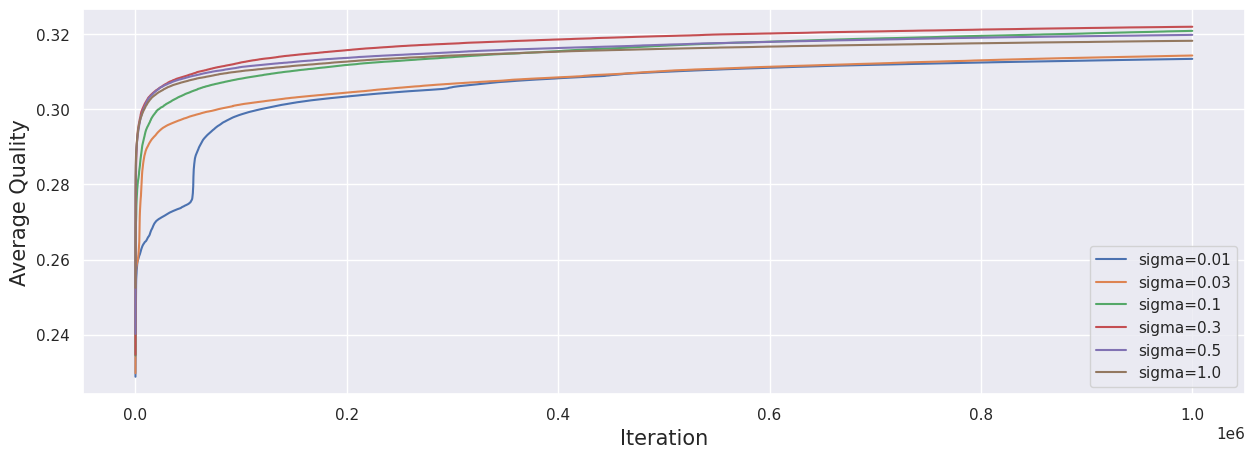

In [20]:
plt.figure(figsize=(15, 5))
final_qualities = []
for cfg in cfgs:
    save_dir = cfg["save_dir"]
    # archive = util.load_pkl(save_dir, "archive")
    data = util.load_pkl(save_dir, "data")
    sigma = cfg["sigma"]
    plt.plot(data['avg_quality'], label=f"sigma={sigma}")
    final_qualities.append(data['avg_quality'][-1])
plt.legend()

plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Average Quality", fontsize=15)

plt.show()

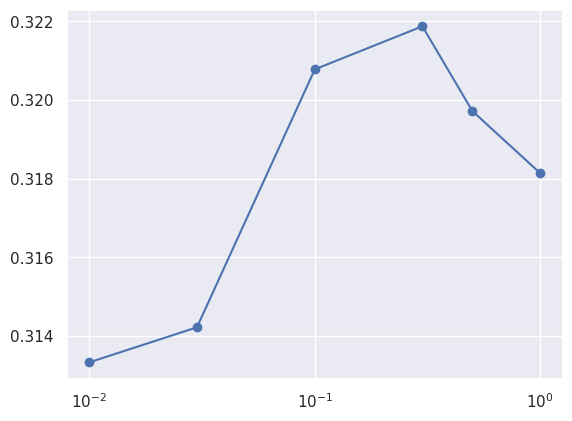

In [21]:
plt.plot([cfg["sigma"] for cfg in cfgs], final_qualities, "o-")
plt.xscale("log")

In [8]:
save_dir = "/home/akarsh_sakana_ai/spaghetti-data/exp2/0_16_gaussian_0.5"
archive = util.load_pkl(save_dir, "archive")
data = util.load_pkl(save_dir, "data")

In [16]:
from PIL import Image
import cv2

cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh', hsv=True)
cppn = FlattenCPPNParameters(cppn)
scan_fn = lambda _, params: (None, cppn.generate_image(params))

archive = util.load_pkl(save_dir, 'archive')
data = util.load_pkl(save_dir, 'data')

_, imgs = jax.lax.scan(scan_fn, None, archive['pheno']['params'])
imgs = np.array(imgs)
print(imgs.shape)
poster = imgs[:6800]
poster = np.pad(poster, ((0, 0), (35, 10), (5, 5), (0, 0)), constant_values=1.)
poster = rearrange(poster, "(R C) H W D -> (R H) (C W) D", R=68, C=100)
for i in range(6800):
    y, x = divmod(i, 100)
    x, y = x*(128+10), y*(128+45)
    txt = f"{nouns[i]}"
    cv2.putText(poster, txt, (x+5, y+12), cv2.FONT_HERSHEY_COMPLEX, .7, (0, 0, 0), 1)  #text,coordinate,font,size of text,color,thickness of font
    txt = f"{archive['quality'][i].item():.3f}"
    cv2.putText(poster, txt, (x+5, y+12+18), cv2.FONT_HERSHEY_COMPLEX, .5, (0, 0, 0), 1)  #text,coordinate,font,size of text,color,thickness of font
Image.fromarray((poster * 255).astype('uint8')).save(f"{save_dir}/poster.png")


ParameterReshaper: 931 parameters detected for optimization.
(6801, 128, 128, 3)


# Visualizing Results

In [15]:
with open(cfgs[0]['noun_file'], 'r') as f:
    nouns = f.read().strip().split('\n')

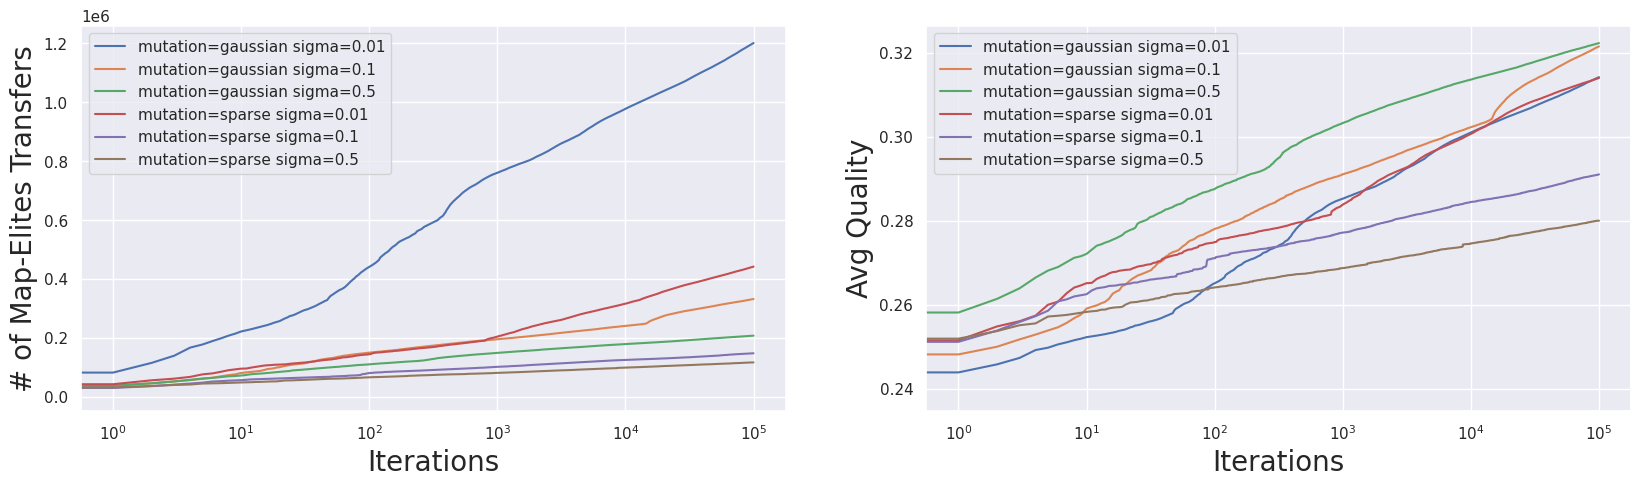

In [7]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
for cfg in cfgs:
    data = util.load_pkl(cfg["save_dir"], 'data')
    plt.plot(data['n_transfers'].cumsum()[::10], label=f"mutation={cfg['mutation']} sigma={cfg['sigma']}")
plt.legend()
plt.xlabel("Iterations", fontsize=20); plt.ylabel("# of Map-Elites Transfers", fontsize=20)
plt.xscale('log')

plt.subplot(122)
for cfg in cfgs:
    data = util.load_pkl(cfg["save_dir"], 'data')
    plt.plot(data['avg_quality'][::10], label=f"mutation={cfg['mutation']} sigma={cfg['sigma']}")
plt.legend()
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Avg Quality", fontsize=20)
plt.xscale('log')
plt.show()

## create and save the posters to the save_dirs

In [18]:
from PIL import Image
import cv2

cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
scan_fn = lambda _, params: (None, cppn.generate_image(params))

for cfg in tqdm(cfgs):
    save_dir = cfg["save_dir"]
    archive = util.load_pkl(save_dir, 'archive')
    data = util.load_pkl(save_dir, 'data')

    _, imgs = jax.lax.scan(scan_fn, None, archive['pheno']['params'])
    imgs = np.array(imgs)
    print(imgs.shape)
    poster = imgs[:6800]
    poster = np.pad(poster, ((0, 0), (35, 10), (5, 5), (0, 0)), constant_values=1.)
    poster = rearrange(poster, "(R C) H W D -> (R H) (C W) D", R=68, C=100)
    for i in range(6800):
        y, x = divmod(i, 100)
        x, y = x*(128+10), y*(128+45)
        txt = f"{nouns[i]}"
        cv2.putText(poster, txt, (x+5, y+12), cv2.FONT_HERSHEY_COMPLEX, .7, (0, 0, 0), 1)  #text,coordinate,font,size of text,color,thickness of font
        txt = f"{archive['quality'][i].item():.3f}"
        cv2.putText(poster, txt, (x+5, y+12+18), cv2.FONT_HERSHEY_COMPLEX, .5, (0, 0, 0), 1)  #text,coordinate,font,size of text,color,thickness of font
    Image.fromarray((poster * 255).astype('uint8')).save(f"{save_dir}/poster.png")


ParameterReshaper: 931 parameters detected for optimization.


  0%|          | 0/6 [00:00<?, ?it/s]

(6801, 128, 128, 3)
(6801, 128, 128, 3)
(6801, 128, 128, 3)
(6801, 128, 128, 3)
(6801, 128, 128, 3)
(6801, 128, 128, 3)


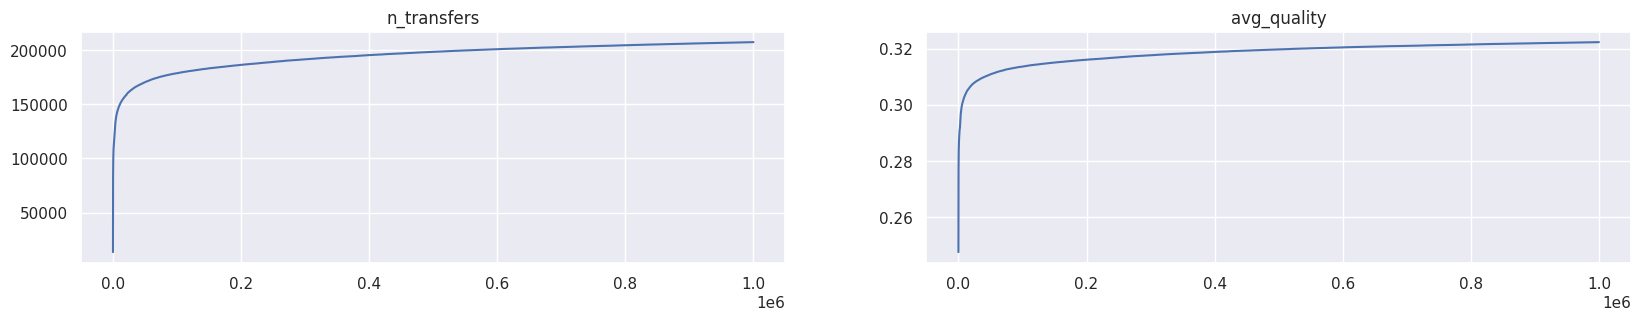

In [8]:
cfg = cfgs[2]
save_dir = cfg["save_dir"]
archive = util.load_pkl(save_dir, 'archive')
data = util.load_pkl(save_dir, 'data')

plt.figure(figsize=(20, 3))
plt.subplot(121); plt.plot(data['n_transfers'].cumsum()); plt.title('n_transfers')
plt.subplot(122); plt.plot(data['avg_quality']); plt.title('avg_quality')
plt.show()


In [9]:
print(jax.tree.map(lambda x: (x.shape), (archive, data)))
print(jax.tree.map(lambda x: (x.size*4/1e6), (archive, data)))

({'pheno': {'params': (6801, 931), 'z_img': (6801, 512)}, 'quality': (6801,), 'z_txt': (6801, 512)}, {'avg_quality': (1000000,), 'n_transfers': (1000000,), 'nid_parent': (1000000, 16), 'percent_archive_filled': (1000000,)})
({'pheno': {'params': 25.326924, 'z_img': 13.928448}, 'quality': 0.027204, 'z_txt': 13.928448}, {'avg_quality': 4.0, 'n_transfers': 4.0, 'nid_parent': 64.0, 'percent_archive_filled': 4.0})


In [10]:
# noun = "dog"
noun = "lunchroom"
nid = nouns.index(noun)

In [11]:
cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
ai = jax.tree.map(lambda x: x[nid], archive)
params = ai['pheno']['params']

ParameterReshaper: 931 parameters detected for optimization.


In [60]:
def viz_feature_maps(features):
    max_features_per_layer = max(jax.tree.map(lambda x: x.shape[-1], features))
    n_layers = len(features)
    n_layers, max_features_per_layer

    plt.figure(figsize=(2*max_features_per_layer, 2*n_layers))
    for i, layer_features in enumerate(features):
        for j, fmap in enumerate(rearrange(layer_features, 'h w c -> c h w')):
            plt.subplot(n_layers, max_features_per_layer, i*max_features_per_layer + j + 1)
            plt.imshow(fmap); plt.xticks([]); plt.yticks([])
            if j==0:
                plt.ylabel(f"{i}", fontsize=25)
    plt.subplot(n_layers, max_features_per_layer, (n_layers-1)*max_features_per_layer + (max_features_per_layer-1) + 1)
    plt.imshow(rgb); plt.axis('off')
    plt.gcf().supylabel("Layer", fontsize=35)
    plt.gcf().supxlabel("Feature Map", fontsize=35)
    plt.suptitle("Feature Maps of CPPN", fontsize=35)
    plt.tight_layout()
    return plt.gcf()

def viz_random_mutations(cppn, params, mutation='gaussian', sigma=0.5):
    def mutate_fn(rng, params):
        if mutation == 'gaussian':
            noise = jax.random.normal(rng, params.shape)
            return params + noise * sigma
        elif mutation == 'sparse':
            rng, _rng = split(rng)
            mask = jax.random.uniform(rng, params.shape) < sigma
            noise = jax.random.normal(_rng, params.shape)
            return noise * mask + params * (1-mask)
        else:
            raise NotImplementedError
    rng = jax.random.PRNGKey(0)
    plt.figure(figsize=(20, 5))
    for i in range(45):
        rng = jax.random.PRNGKey(i)
        paramsp = mutate_fn(rng, params)
        imgp = cppn.generate_image(paramsp)
        plt.subplot(3, 15, i+1); plt.imshow(imgp); plt.axis('off')
    plt.suptitle("Random mutations of CPPN", fontsize=25)
    plt.tight_layout()
    return plt.gcf()

def viz_weight_influences(cppn, params):
    params = jnp.array(params)

    weight_sweep = jnp.linspace(-3, 3, 11)

    def get_img(weight_idx, weight_val):
        return cppn.generate_image(params.at[weight_idx].set(weight_val))
    get_img = jax.jit(jax.vmap(get_img, in_axes=(None, 0)))

    def get_influence_img(weight_idx):
        imgs = get_img(weight_idx, weight_sweep) # (n_sweeps, H, W, 3)
        return jnp.var(imgs, axis=0).mean(axis=-1) # (H, W)

    imgs = [get_influence_img(weight_idx) for weight_idx in range(len(params))]
    imgs = jnp.stack(imgs, axis=0) # (n_params, H, W)
    weight_importance = imgs.mean(axis=(1, 2))

    imgs = imgs[jnp.argsort(weight_importance)[::-1]]
    poster = rearrange(imgs[:600], "(R C) H W ... -> (R H) (C W) ...", R=20)
    plt.figure(figsize=(20, 20))
    plt.imshow(poster); plt.xticks([]); plt.yticks([])
    plt.title("Weight Influences of CPPN", fontsize=25)
    return weight_importance
def viz_sweep_weights(cppn, params, weight_importance):
    params = jnp.array(params)
    rng = jax.random.PRNGKey(0)

    n_sweeps, granularity = 72, 7
    # weight_idxs = jax.random.permutation(rng, cppn.n_params)[:n_sweeps]
    # plt.figure(figsize=(1*n_sweeps, 1*granularity))

    weight_idxs = jnp.argsort(weight_importance)[::-1][:n_sweeps]
    plt.figure(figsize=(20, 24))
    for i, weight_idx in enumerate(weight_idxs):
        img = jnp.concatenate([cppn.generate_image(params.at[weight_idxs[i]].set(val)) for val in jnp.linspace(-3, 3, granularity)], axis=1)
        plt.subplot(24, 3, i+1)
        plt.imshow(img); plt.xticks([]); plt.yticks([])
        plt.ylabel(f"{weight_idx}", fontsize=10)
    plt.suptitle("Sweeping weights of CPPN", fontsize=20, y=1.01)
    plt.gcf().supylabel("Weight Index", fontsize=20)
    plt.tight_layout()
    return plt.gcf()

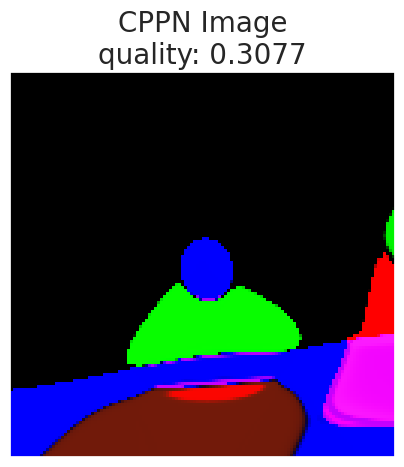

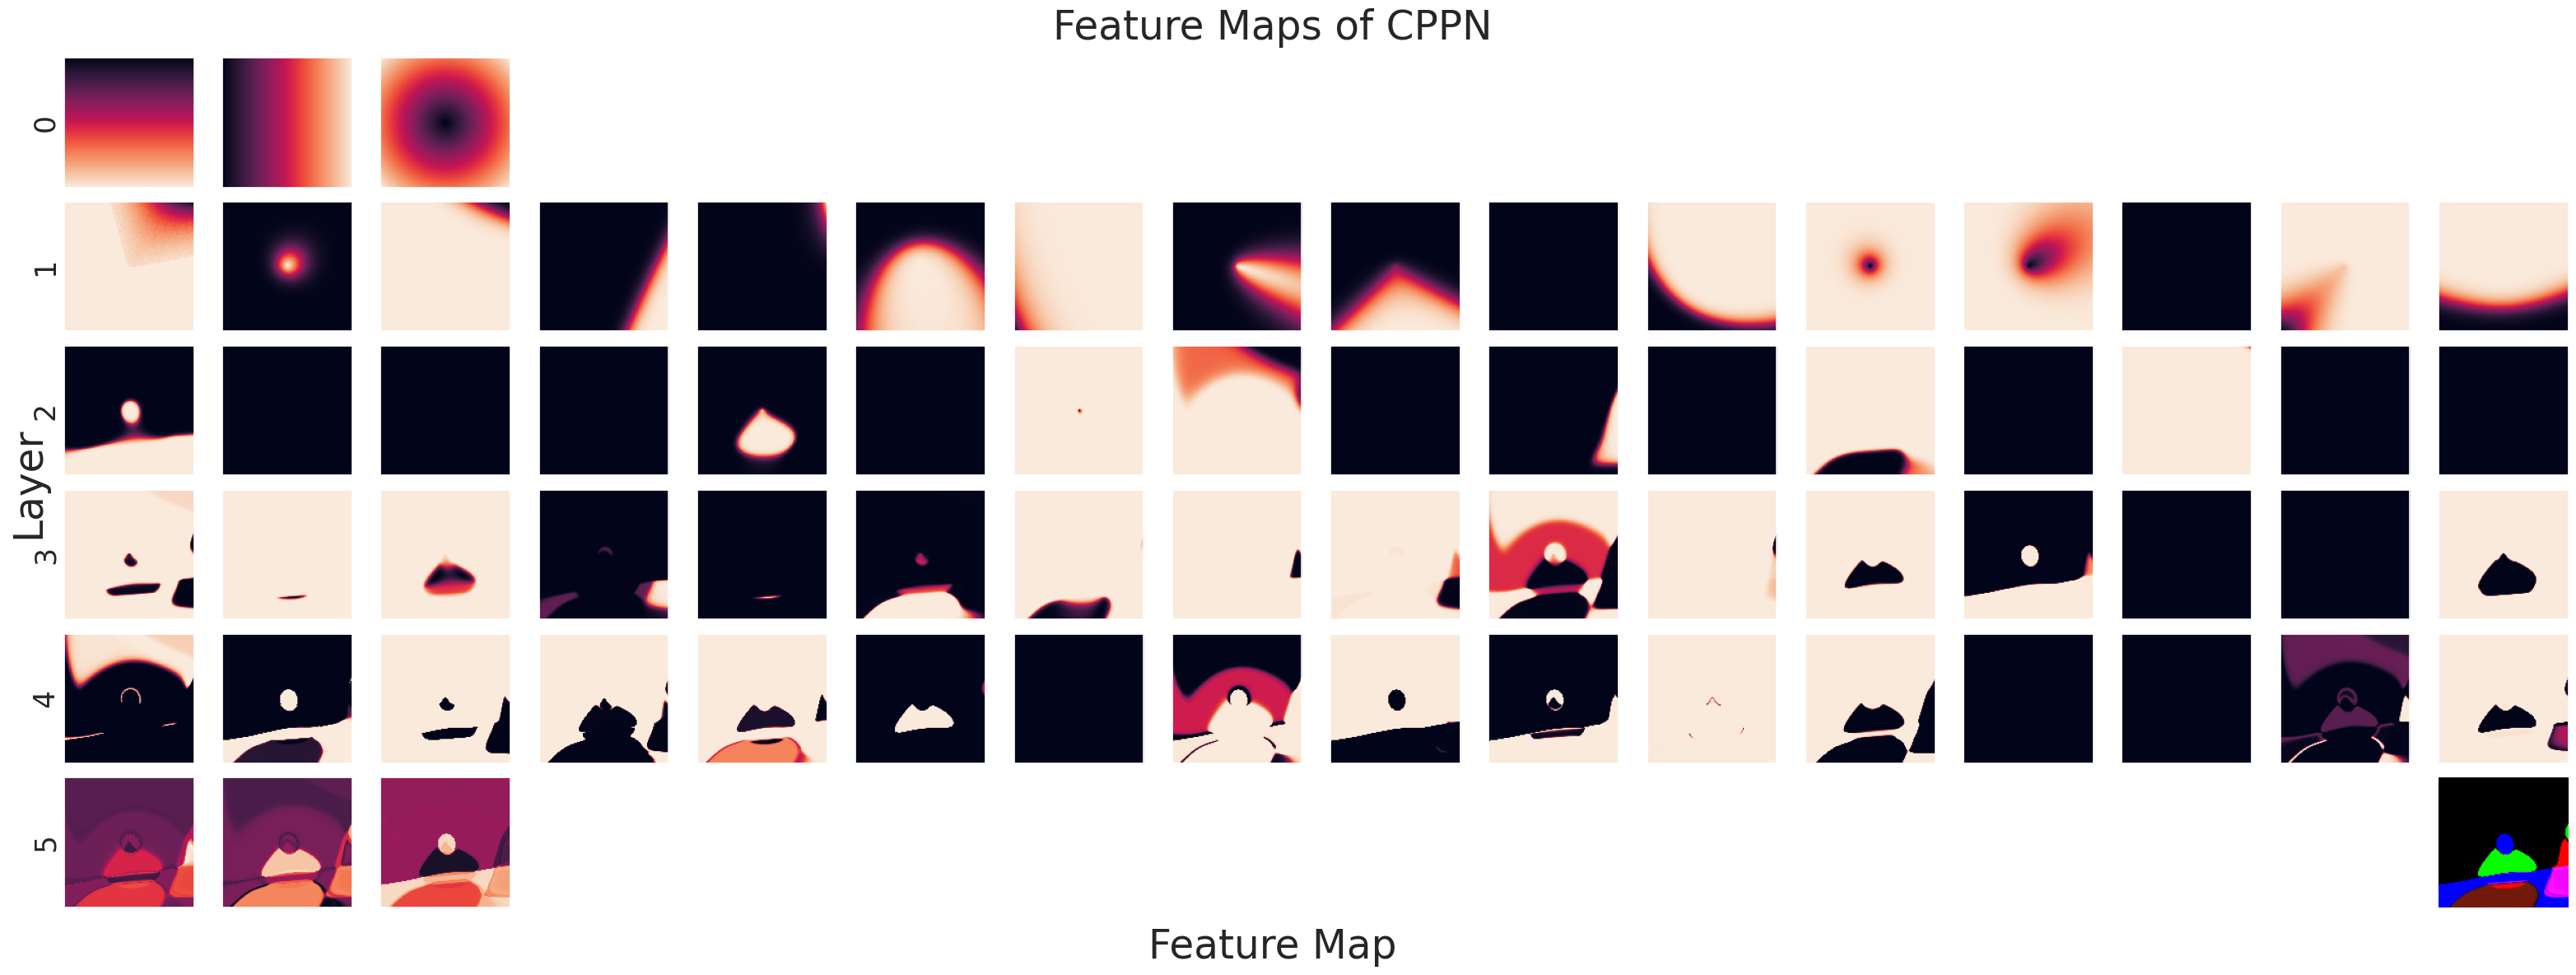

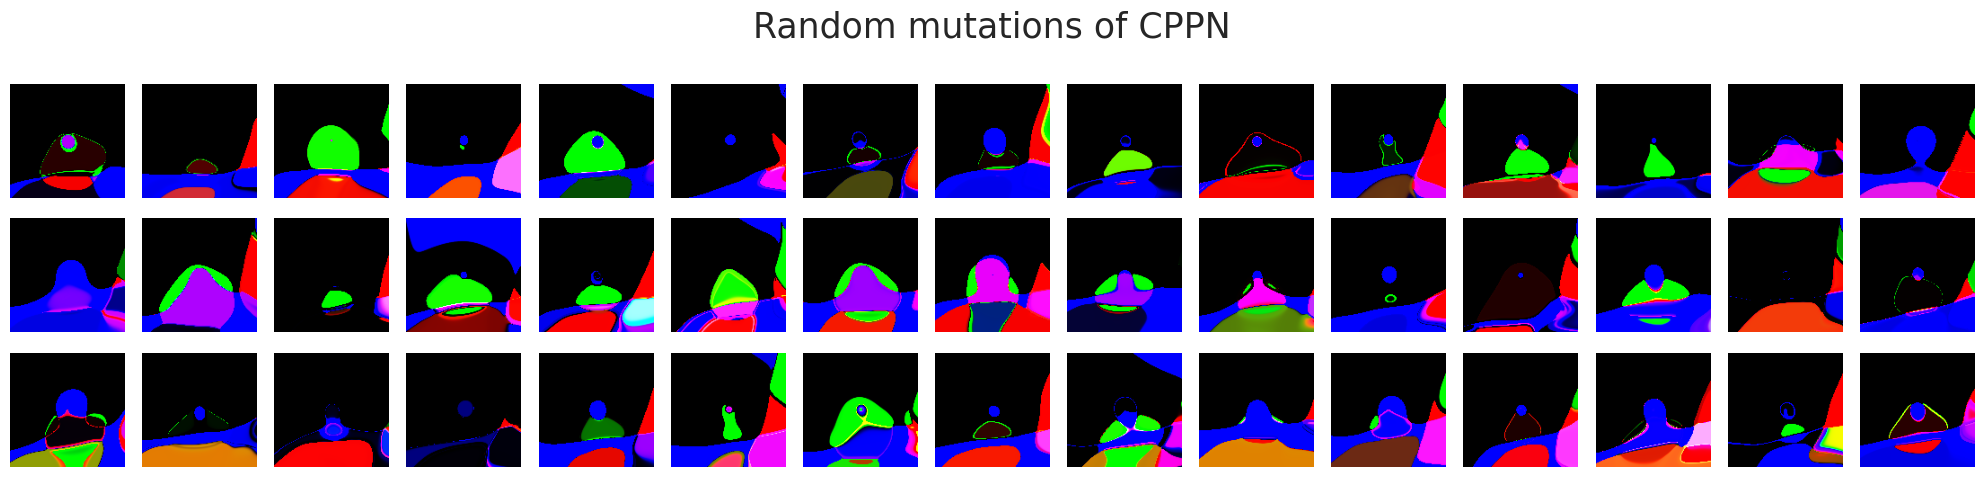

  0%|          | 0/931 [00:00<?, ?it/s]

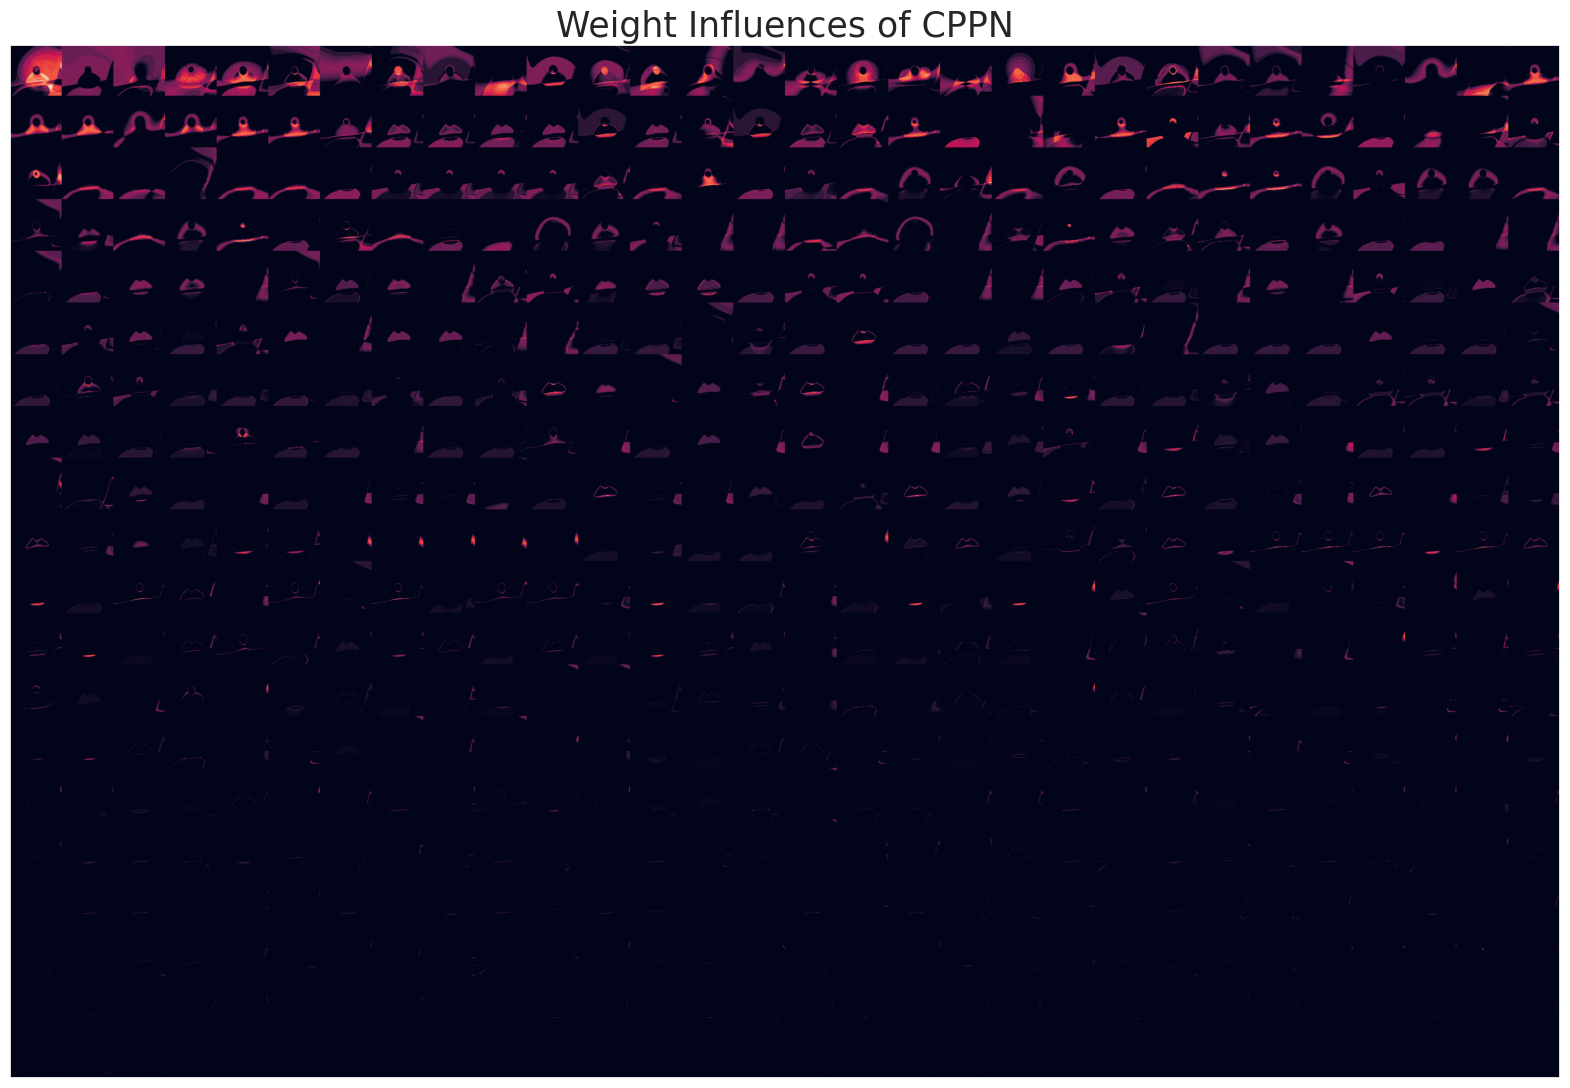

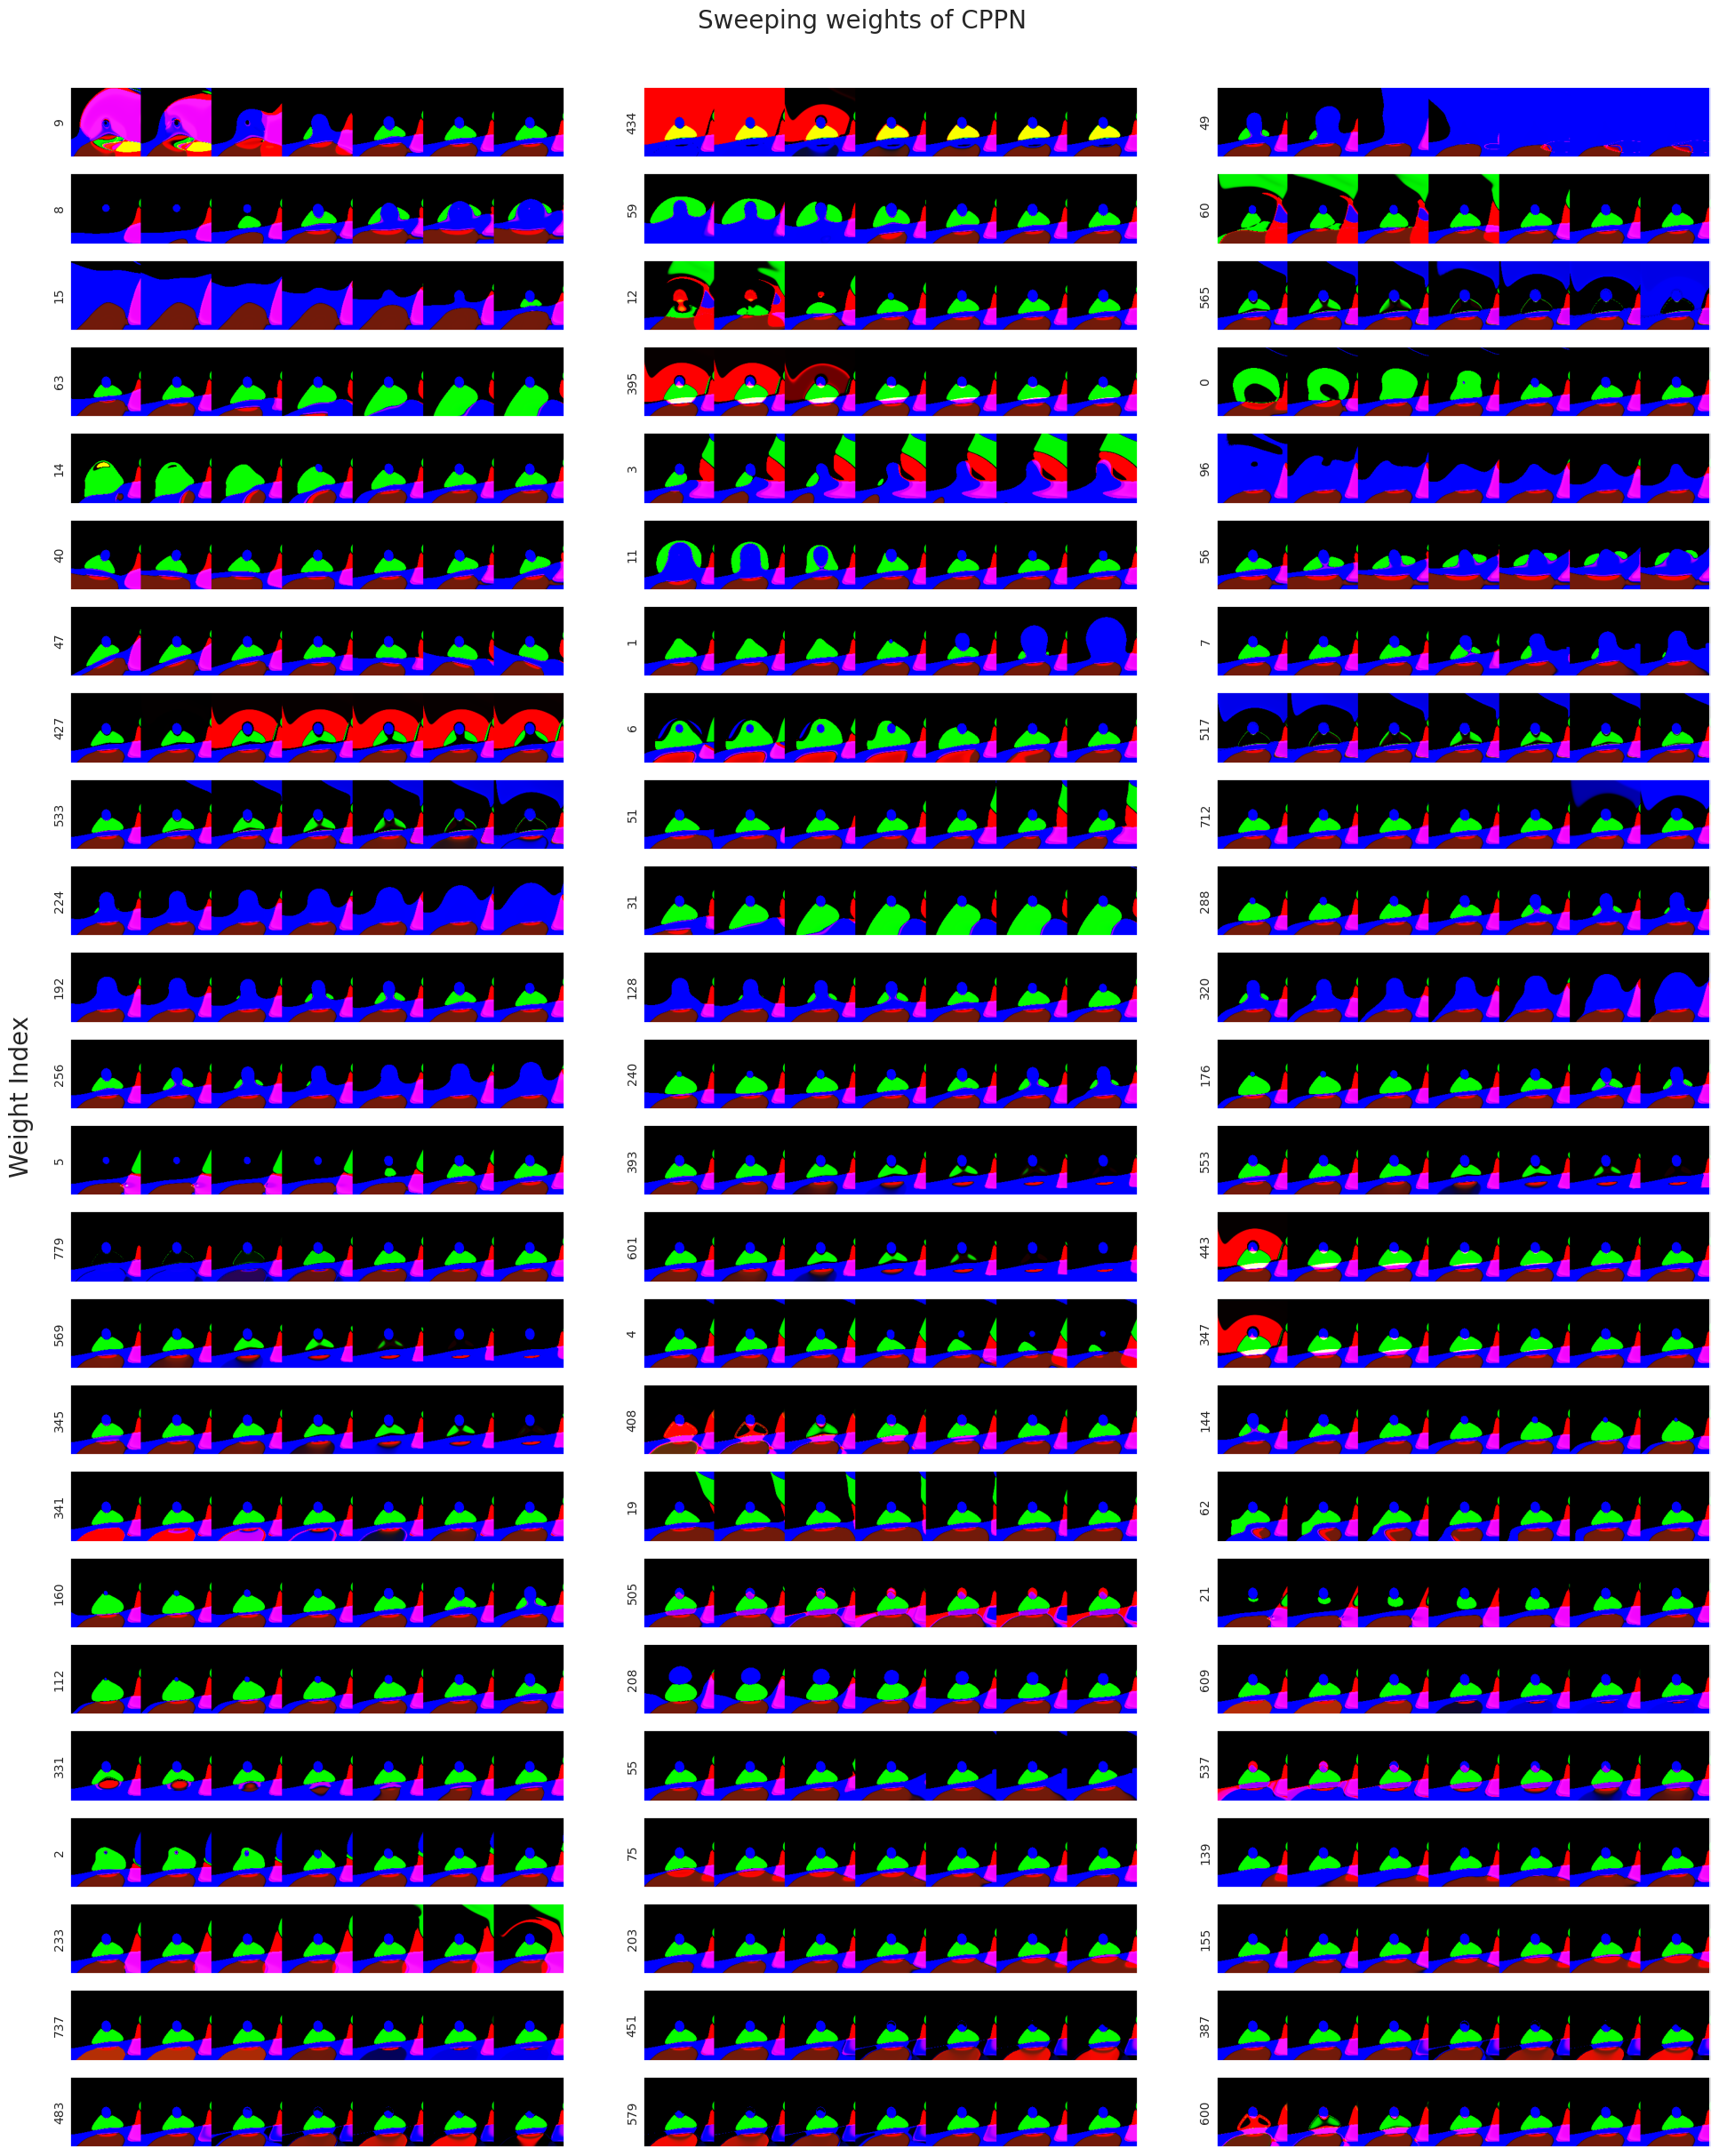

In [13]:
rgb, features = cppn.generate_image(params, intermediate_features=True)

plt.figure(figsize=(5, 5))
plt.imshow(rgb); plt.grid(False); plt.xticks([]); plt.yticks([]);
plt.title(f"CPPN Image\nquality: {ai['quality'].item():.4f}", fontsize=20)
plt.show()

viz_feature_maps(features)
plt.show()
viz_random_mutations(cppn, params, mutation='gaussian', sigma=0.5)
plt.show()
weight_importance = viz_weight_influences(cppn, params)
plt.show()
viz_sweep_weights(cppn, params, weight_importance)
plt.show()

In [18]:
def train_sgd_params(rng, params_original, cppn, n_iters=100000, lr=3e-4):
    rgb_original = cppn.generate_image(params_original)

    def loss_fn(params):
        rgb = cppn.generate_image(params)
        return ((rgb-rgb_original)**2).mean()

    grad_fn = jax.jit(jax.value_and_grad(loss_fn))

    @jax.jit
    def train_step(state, _):
        loss, grad = grad_fn(state.params)
        state = state.apply_gradients(grads=grad)
        return state, loss

    params_sgd = jax.random.normal(rng, params_original.shape)*0.1
    tx = optax.adam(learning_rate=lr)
    state = TrainState.create(apply_fn=None, params=params_sgd, tx=tx)
    state, losses = jax.lax.scan(train_step, state, None, length=n_iters)
    params_sgd = state.params
    return params_sgd, losses

In [19]:
params_sgd, losses = train_sgd_params(jax.random.PRNGKey(0), params, cppn)

Text(0, 0.5, 'SGD Loss')

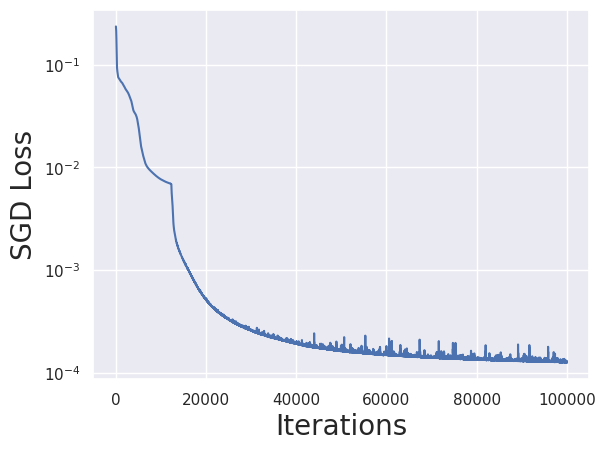

In [28]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Iterations", fontsize=20); plt.ylabel("SGD Loss", fontsize=20)

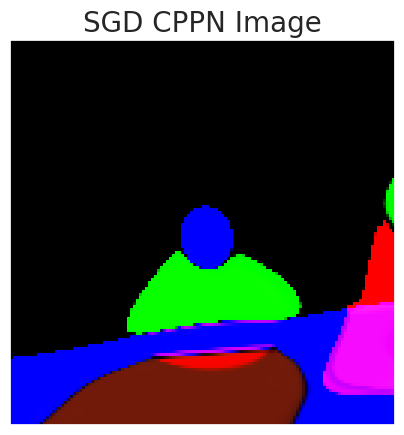

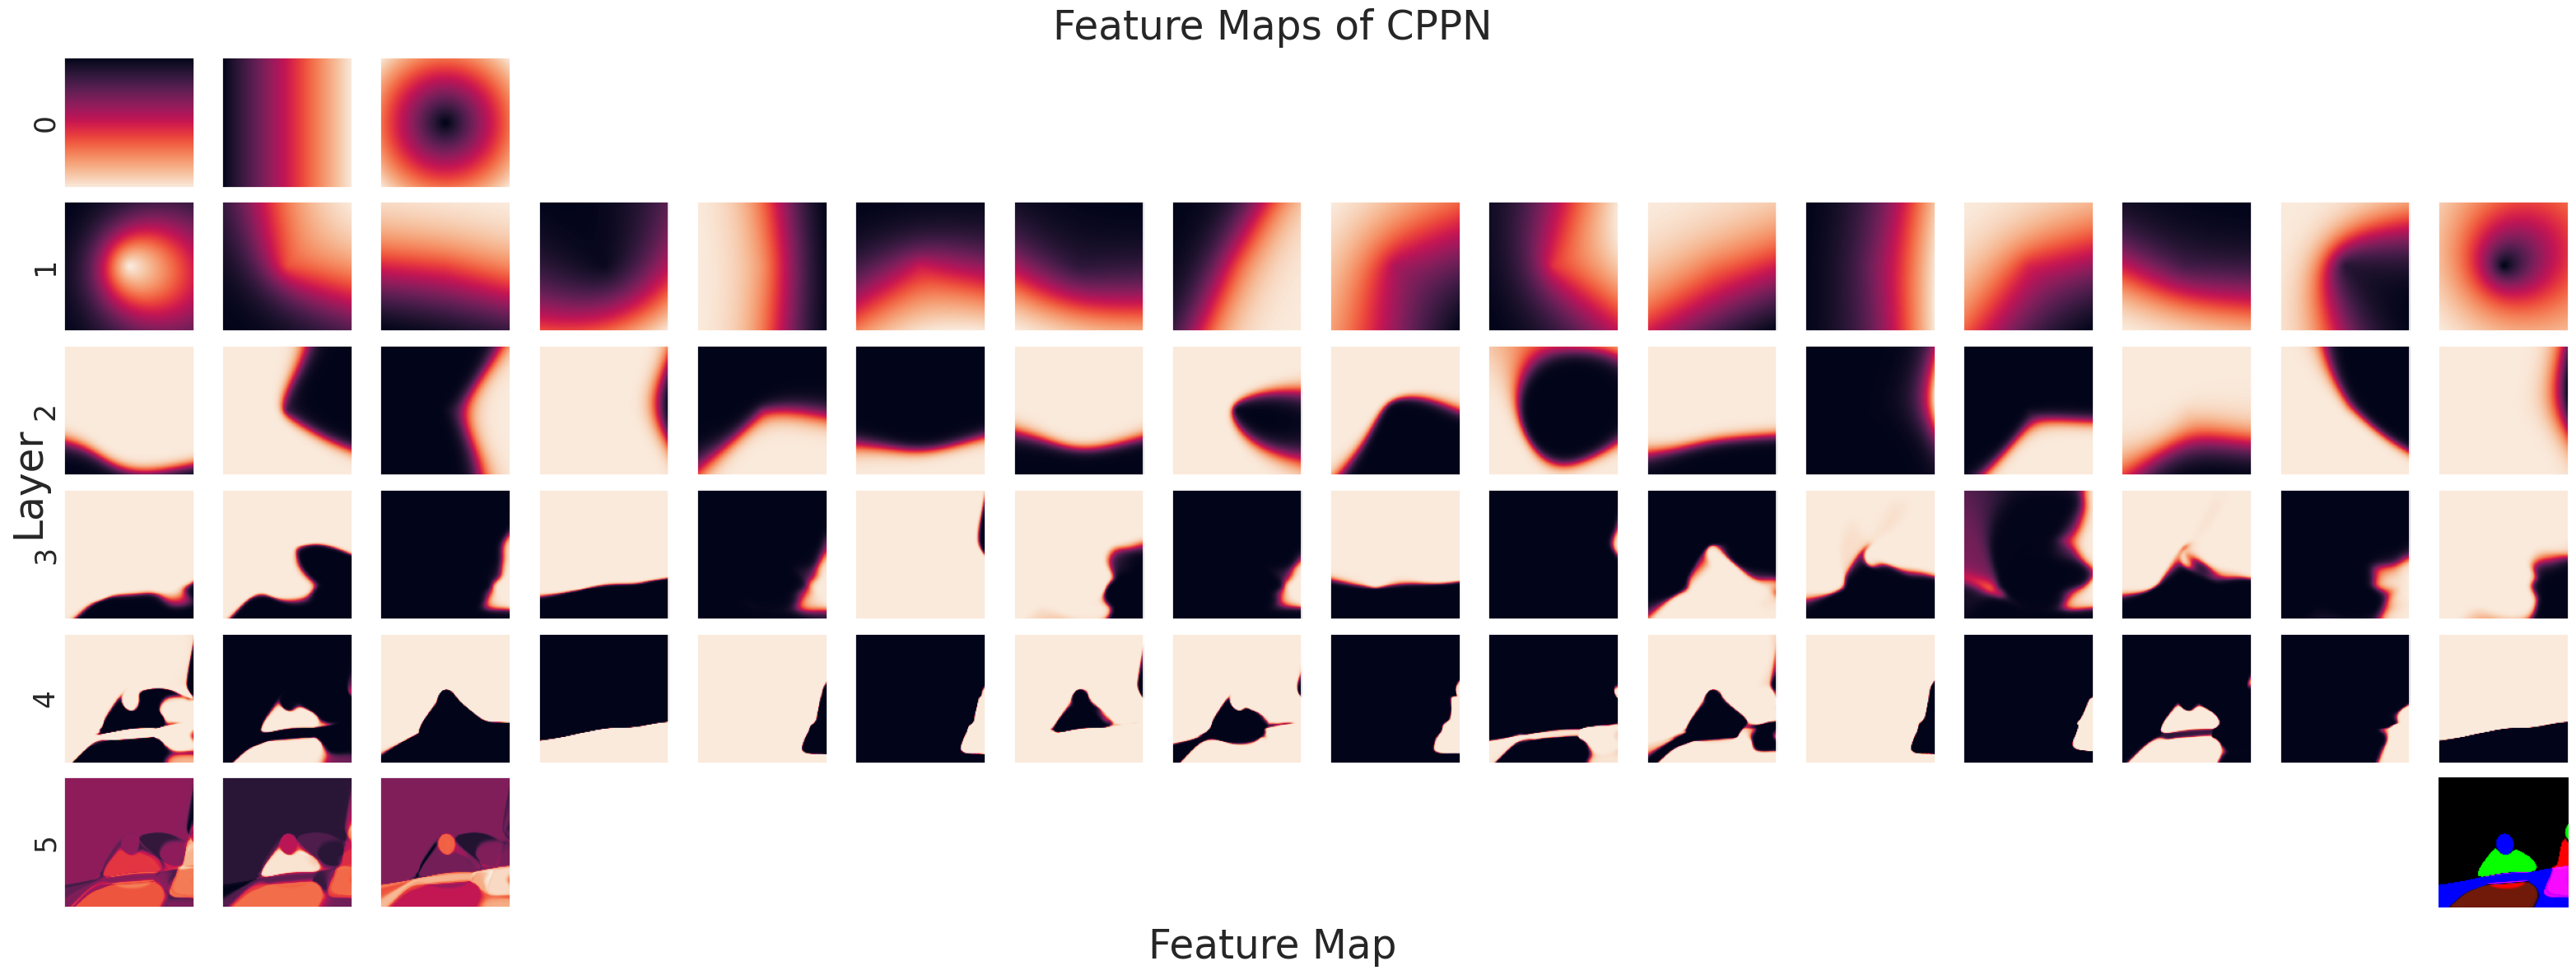

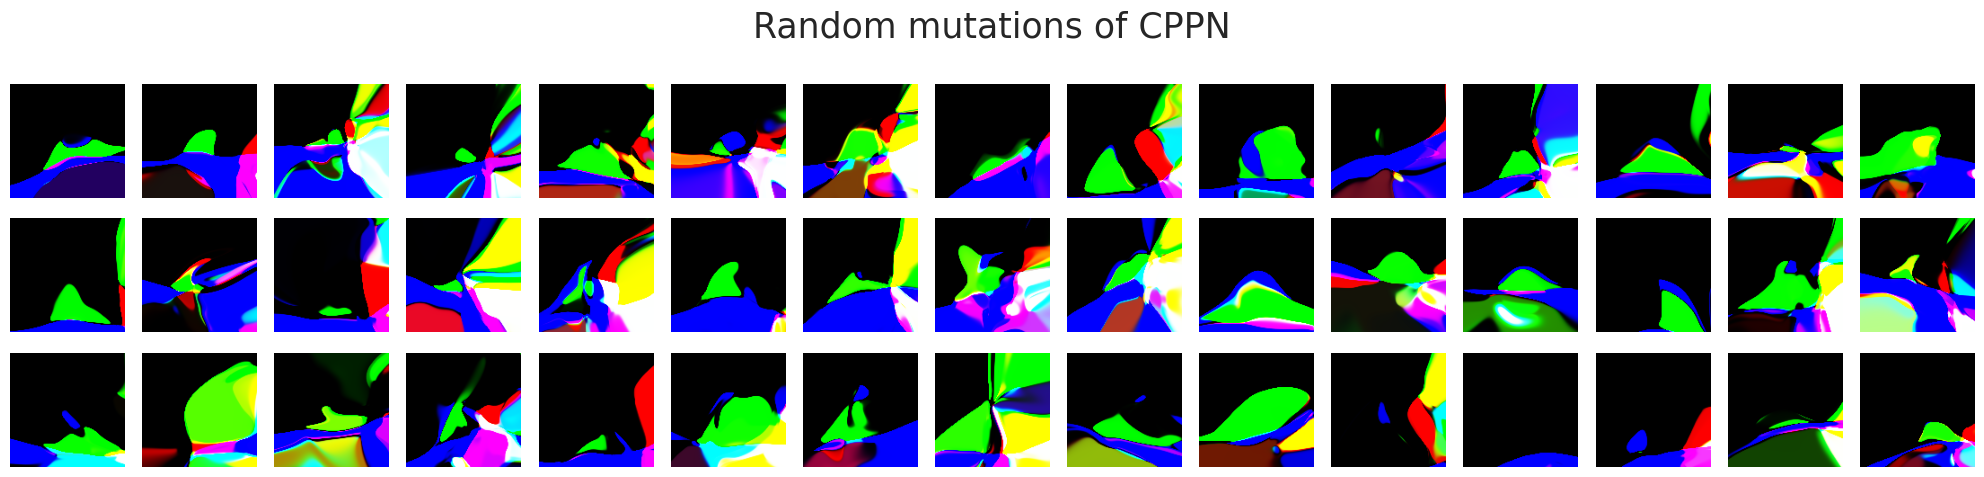

  0%|          | 0/931 [00:00<?, ?it/s]

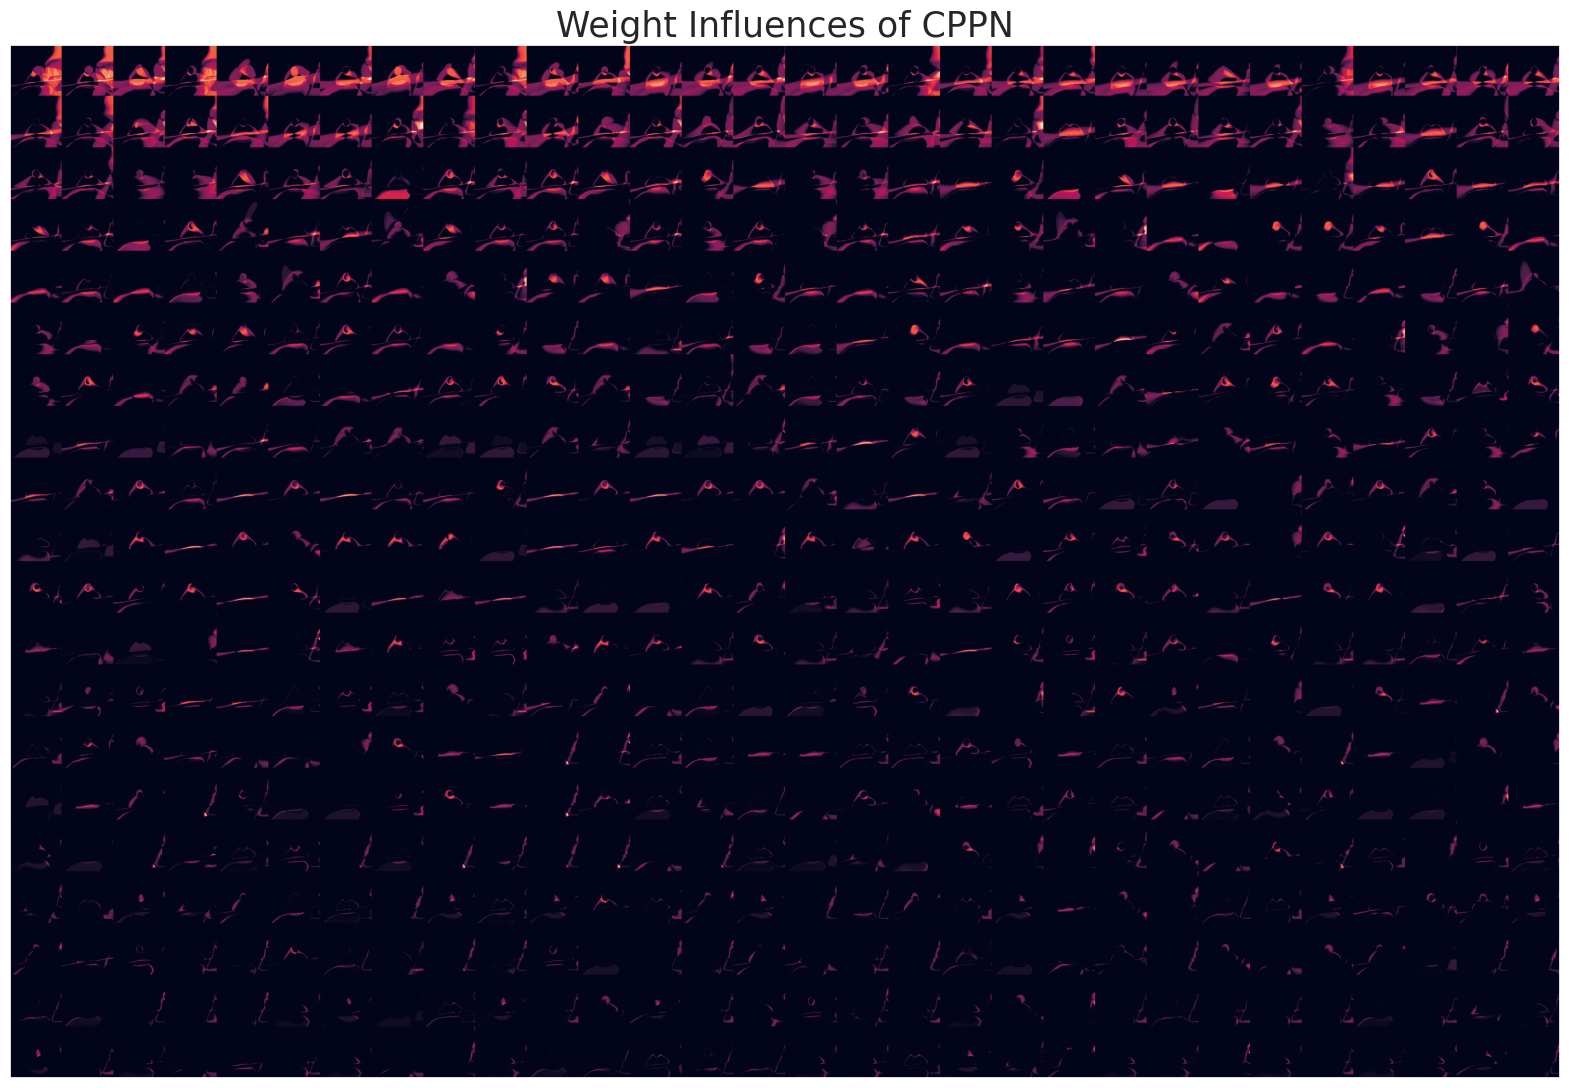

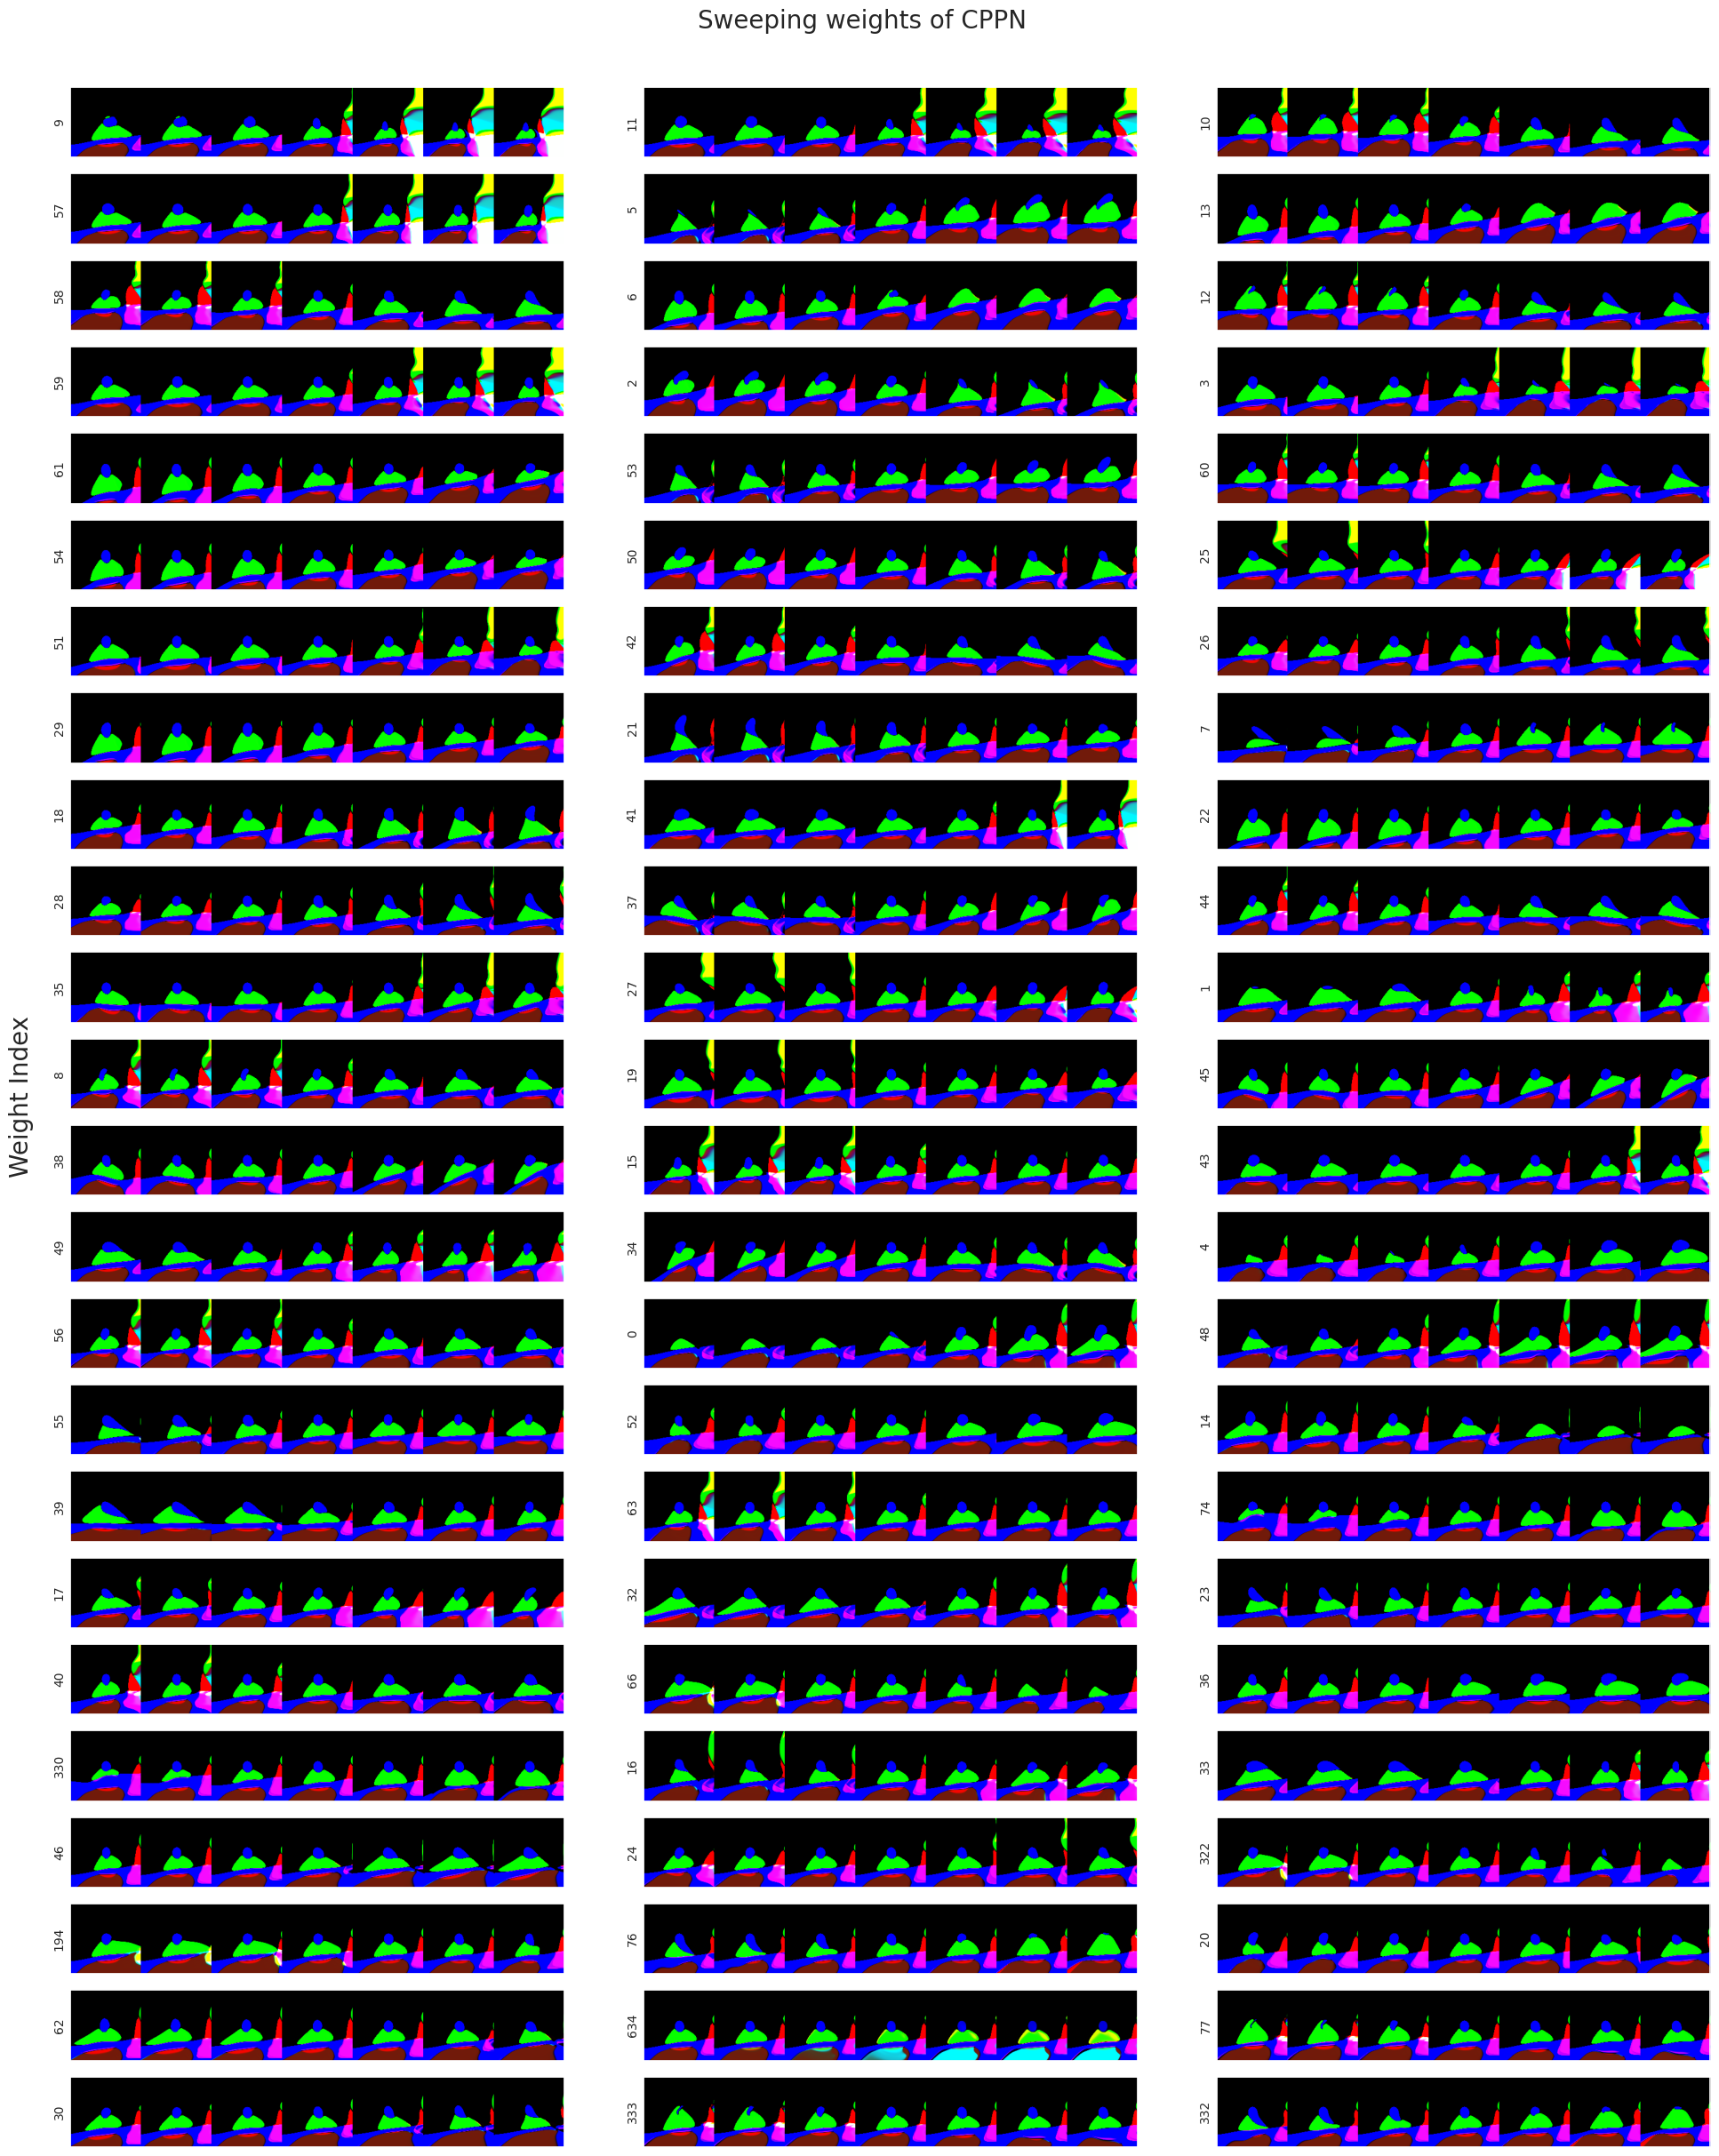

In [30]:
rgb, features = cppn.generate_image(params_sgd, intermediate_features=True)

plt.figure(figsize=(5, 5))
plt.imshow(rgb); plt.grid(False); plt.xticks([]); plt.yticks([]);
plt.title(f"SGD CPPN Image", fontsize=20)
plt.show()

viz_feature_maps(features)
plt.show()
viz_random_mutations(cppn, params_sgd, mutation='gaussian', sigma=0.5)
plt.show()
weight_importance = viz_weight_influences(cppn, params_sgd)
plt.show()
viz_sweep_weights(cppn, params_sgd, weight_importance)
plt.show()

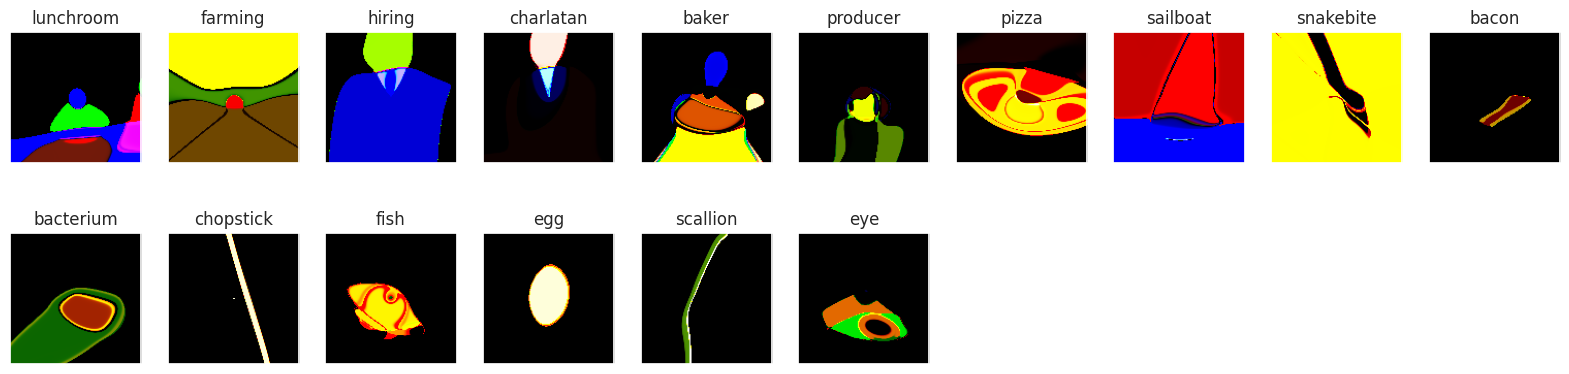

In [66]:
nouns_cool = ["lunchroom", "farming", "hiring", "charlatan", "baker", "producer", "pizza", "sailboat", "snakebite", "bacon", "bacterium", "chopstick", "fish", "egg", "scallion", "eye"]

plt.figure(figsize=(20, 10))
for i, noun in enumerate(nouns_cool):
    nid = nouns.index(noun)
    ai = jax.tree.map(lambda x: x[nid], archive)
    params = ai['pheno']['params']
    plt.subplot(4, 10, i+1)
    plt.imshow(cppn.generate_image(params)); plt.grid(False); plt.xticks([]); plt.yticks([]);
    plt.title(f"{noun}")
plt.show()

In [64]:
for noun in tqdm(nouns_cool):
    print(noun)

    nid = nouns.index(noun)
    ai = jax.tree.map(lambda x: x[nid], archive)
    params = ai['pheno']['params']
    params_sgd, losses = train_sgd_params(jax.random.PRNGKey(0), params, cppn)

    for name, p in zip(['map_elites', 'sgd'], [params, params_sgd]):
        os.makedirs(f"{save_dir}/noun_viz/{noun}", exist_ok=True)

        rgb, features = cppn.generate_image(p, intermediate_features=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb); plt.grid(False); plt.xticks([]); plt.yticks([]);
        plt.title(f"{name} CPPN Image", fontsize=20)
        plt.savefig(f"{save_dir}/noun_viz/{noun}/image_{name}.png", bbox_inches='tight'); plt.close()

        viz_feature_maps(features)
        plt.savefig(f"{save_dir}/noun_viz/{noun}/features_{name}.png", bbox_inches='tight'); plt.close()
        viz_random_mutations(cppn, p, mutation='gaussian', sigma=0.5)
        plt.savefig(f"{save_dir}/noun_viz/{noun}/mutations_{name}.png", bbox_inches='tight'); plt.close()
        weight_importance = viz_weight_influences(cppn, p)
        plt.savefig(f"{save_dir}/noun_viz/{noun}/weight_influences_{name}.png", bbox_inches='tight'); plt.close()
        viz_sweep_weights(cppn, p, weight_importance)
        plt.savefig(f"{save_dir}/noun_viz/{noun}/weight_sweeps_{name}.png", bbox_inches='tight'); plt.close()

  0%|          | 0/2 [00:00<?, ?it/s]

scallion
eye


In [231]:
from sklearn.cluster import SpectralClustering
mat = cppn.param_reshaper.reshape_single(params)['params']['Dense_1']['kernel'].copy()
mat = jnp.array(mat)
mat = (mat>1.).astype('float32')

In [232]:
plt.imshow(mat)

In [233]:
affinity1 = mat @ mat.T
affinity2 = mat.T @ mat
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.imshow(affinity1); plt.colorbar()
plt.subplot(122); plt.imshow(affinity2); plt.colorbar()

In [235]:
for n_clusters in [2, 4, 6, 8]:
    clustering1 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0).fit(affinity1)
    clustering2 = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0).fit(affinity2)
    plt.imshow(mat[np.argsort(clustering1.labels_[::-1])][:, np.argsort(clustering2.labels_[::-1])])
    plt.show()

In [213]:
plt.hist(params, bins=50);
plt.hist(params_sgd, bins=50, color='red', alpha=0.5);

In [255]:
cppn = CPPN(n_layers=8, d_hidden=8, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
plt.figure(figsize=(20, 5))
for i in range(4*20):
    p = jax.random.normal(jax.random.PRNGKey(i), (cppn.n_params,))
    img = cppn.generate_image(p)
    plt.subplot(4, 20, i+1)
    plt.imshow(img); plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:

rng = jax.random.PRNGKey(0)
p = jax.random.normal(rng, (40, cppn.n_params))

cppn = CPPN(n_layers=4, d_hidden=4, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
rgb = jax.vmap(cppn.generate_image)(p)
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(rgb, "(R C) H W D -> (R H) (C W) D", R=4)); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.show()

cppn = CPPN(n_layers=4, d_hidden=4, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
rgb = jax.vmap(cppn.generate_image)(p)
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(rgb, "(R C) H W D -> (R H) (C W) D", R=4)); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.show()

TypeError: CPPN.__init__() got an unexpected keyword argument 'hsv'

In [52]:
N, K = 10000, 100

rng = jax.random.PRNGKey(0)
x = jax.random.uniform(rng, (N, 2), minval=0, maxval=1000)

def get_dist(idx, idx_nn):
    return jnp.linalg.norm(x[idx] - x[idx_nn], axis=-1)
get_dist = jax.jit(jax.vmap(get_dist, in_axes=(0, 0)))


ds = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    idx = jax.random.randint(rng, (N, K), minval=0, maxval=N)
    d = get_dist(jnp.arange(N), idx)
    ds.append(d.mean())
ds = jnp.array(ds)
ds0 = ds

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
idx = jax.random.randint(rng, (N, K), minval=0, maxval=N)
d = get_dist(jnp.arange(N), idx)

ds = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    idx_new = jax.random.randint(rng, (N, K), minval=0, maxval=N)
    idx = jnp.concatenate([idx, idx_new], axis=1)
    d = get_dist(jnp.arange(N), idx)
    def select_fn(x, idx):
        return x[idx]
    idx = jax.vmap(select_fn)(idx, d.argsort(axis=-1)[:, :K])
    d = get_dist(jnp.arange(N), idx)
    ds.append(d.mean())
ds = jnp.array(ds)
ds1 = ds

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
idx = jax.random.randint(rng, (N, K), minval=0, maxval=N)
d = get_dist(jnp.arange(N), idx)

ds = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    idx_new = jax.random.randint(rng, (N, K), minval=0, maxval=N)
    idx = jnp.concatenate([idx, idx_new], axis=1)
    d = get_dist(jnp.arange(N), idx)
    def select_fn(x, idx):
        return x[idx]
    idx = jax.vmap(select_fn)(idx, d.argsort(axis=-1)[:, :K])
    d = get_dist(jnp.arange(N), idx)

    rng, _rng = split(rng)
    idx_new = jax.random.randint(rng, (N, K), minval=0, maxval=N)
    idx = jnp.concatenate([idx, idx_new], axis=1)
    d = get_dist(jnp.arange(N), idx)
    def select_fn(x, idx):
        return x[idx]
    idx = jax.vmap(select_fn)(idx, d.argsort(axis=-1)[:, :K])
    d = get_dist(jnp.arange(N), idx)


    ds.append(d.mean())
ds = jnp.array(ds)
ds2 = ds


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
idx = jax.random.randint(rng, (N, K), minval=0, maxval=N)
d = get_dist(jnp.arange(N), idx)

def sample_from_neighbors(rng, idx):
    def sample_from_neighbors_single(rng, row):
        rand = jax.random.randint(rng, (K,), minval=0, maxval=K)
        return idx[row, rand]
    return jax.vmap(sample_from_neighbors_single)(split(rng, N), idx)

ds = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    idx_new = jax.random.randint(rng, (N, K), minval=0, maxval=N)
    idx = jnp.concatenate([idx, idx_new], axis=1)
    d = get_dist(jnp.arange(N), idx)
    def select_fn(x, idx):
        return x[idx]
    idx = jax.vmap(select_fn)(idx, d.argsort(axis=-1)[:, :K])
    d = get_dist(jnp.arange(N), idx)

    rng, _rng = split(rng)
    idx_new = sample_from_neighbors(rng, idx)
    idx = jnp.concatenate([idx, idx_new], axis=1)
    d = get_dist(jnp.arange(N), idx)
    def select_fn(x, idx):
        return x[idx]
    idx = jax.vmap(select_fn)(idx, d.argsort(axis=-1)[:, :K])
    d = get_dist(jnp.arange(N), idx)

    ds.append(d.mean())
ds = jnp.array(ds)
ds3 = ds


  0%|          | 0/1000 [00:00<?, ?it/s]

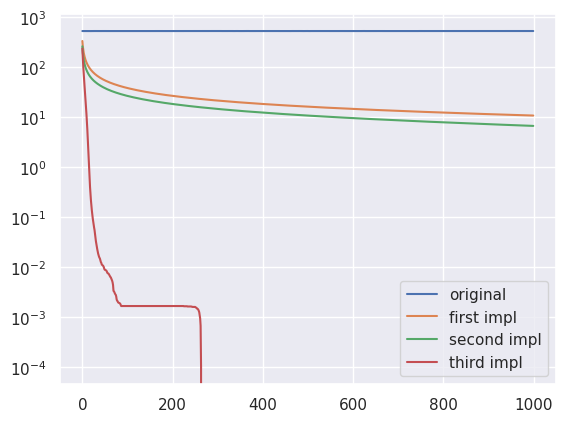

In [75]:
plt.plot(ds0, label='original')
plt.plot(ds1, label='first impl')
plt.plot(ds2, label='second impl')
plt.plot(ds3, label='third impl')
plt.legend()
plt.yscale('log')
plt.show()